In previous parts of this tutorial on Neural ODEs we have examined problems of the form $\dot{x} = f_{\theta}(x)$ with trainable parameters $\theta$. This neural ordinary differential equation can be solved by backpropagating through a differential ODE solver to obtain future values of the learned system: $x_{k+1} = \text{ODESolve}(f_{\theta}(x_k))$ 

More generally, the Neural ODE is of the form below where initial conditions are subject to a read-in map, dynamics are modeled by a neural network parameterized by $f_\theta$ and resultant outputs are subject to a read-out map

$$
y \approx \ell_1^\theta(z_T), \quad \text{where} \quad z_t = z_0 + \int_0^t f_\theta(z_s) \, ds \quad \text{and} \quad z_0 = \ell_2^\theta(x).
$$

#### Motivation for Neural Controlled Differential Equation: Irregular Sampled Data and the Time Dimension:

Neural ODEs (Neural Ordinary Differential Equations) elegantly bridge machine learning and differential equations, allowing the use of well-established tools from differential equations in machine learning models. They align well with the manifold hypothesis by describing a flow that evolves the data manifold. However, Neural ODEs have not yet been fully applied to sequential data like time series. In traditional Neural ODEs, the time dimension is an internal detail used for integration, but this dimension suggests the potential for extending the model to handle sequential data. For ordered data (e.g., $x_0, \ldots, x_n$), the challenge is to extend the initial condition $z_0 = \ell_2^\theta(x)$ to a form like \(z_0 = \ell(x_0), \ldots, z_n = \ell(x_n)\), aligning the artificial time dimension with the data's natural order. The main difficulty lies in the fact that once the parameters \(\theta\) are learned, the solution of the ODE is fixed by the initial conditions.


In [1]:
import math
import torch

In [2]:
def get_data(num_timepoints=100):
    t = torch.linspace(0., 4 * math.pi, num_timepoints)

    start = torch.rand(128) * 2 * math.pi
    x_pos = torch.cos(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos[:64] *= -1
    y_pos = torch.sin(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos += 0.01 * torch.randn_like(x_pos)
    y_pos += 0.01 * torch.randn_like(y_pos)
    ######################
    # Easy to forget gotcha: time should be included as a channel; Neural CDEs need to be explicitly told the
    # rate at which time passes. Here, we have a regularly sampled dataset, so appending time is pretty simple.
    ######################
    X = torch.stack([t.unsqueeze(0).repeat(128, 1), x_pos, y_pos], dim=2)
    y = torch.zeros(128)
    y[:64] = 1

    perm = torch.randperm(128)
    X = X[perm]
    y = y[perm]

    ######################
    # X is a tensor of observations, of shape (batch=128, sequence=100, channels=3)
    # y is a tensor of labels, of shape (batch=128,), either 0 or 1 corresponding to anticlockwise or clockwise
    # respectively.
    ######################
    return X, y

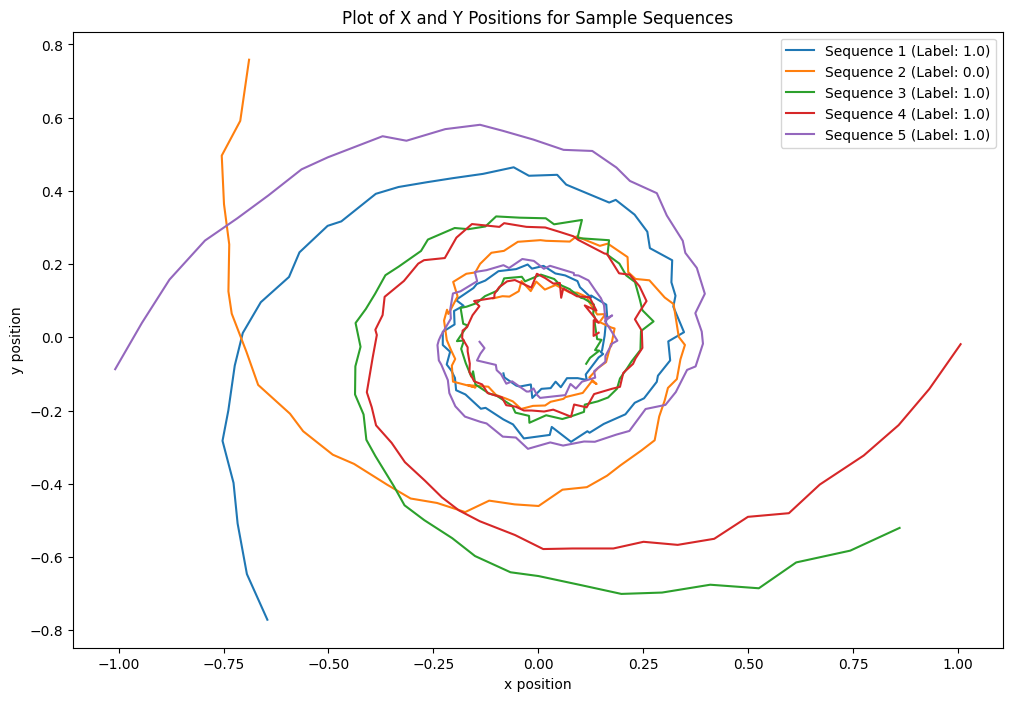

In [8]:
train_X, train_y = get_data()

from matplotlib import pyplot as plt 

# Plot a few sequences
plt.figure(figsize=(12, 8))

X = train_X
y = train_y

for i in range(5):
    plt.plot(X[i, :, 1].numpy(), X[i, :, 2].numpy(), label=f'Sequence {i + 1} (Label: {y[i].item()})')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Plot of X and Y Positions for Sample Sequences')
plt.legend()
plt.show()

In [ ]:
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.linear1 = torch.nn.Linear(hidden_channels, 128)
        self.linear2 = torch.nn.Linear(128, input_channels * hidden_channels)

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z
    


    ###########################################################################################

class MLP(Block):
"""
Multi-Layer Perceptron consistent with blocks interface
"""

def __init__(
    self,
    insize,
    outsize,
    bias=True,
    linear_map=slim.Linear,
    nonlin=SoftExponential,
    hsizes=[64],
    linargs=dict(),
):
    """

    :param insize: (int) dimensionality of input
    :param outsize: (int) dimensionality of output
    :param bias: (bool) Whether to use bias
    :param linear_map: (class) Linear map class from neuromancer.slim.linear
    :param nonlin: (callable) Elementwise nonlinearity which takes as input torch.Tensor and outputs torch.Tensor of same shape
    :param hsizes: (list of ints) List of hidden layer sizes
    :param linargs: (dict) Arguments for instantiating linear layer
    :param dropout: (float) Dropout probability
    """
    super().__init__()
    self.in_features, self.out_features = insize, outsize
    self.nhidden = len(hsizes)
    sizes = [insize] + hsizes + [outsize]
    self.nonlin = nn.ModuleList(
        [nonlin() for k in range(self.nhidden)] + [nn.Identity()]
    )
    self.linear = nn.ModuleList(
        [
            linear_map(sizes[k], sizes[k + 1], bias=bias, **linargs)
            for k in range(self.nhidden + 1)
        ]
    )

def reg_error(self):
    return sum([k.reg_error() for k in self.linear if hasattr(k, "reg_error")])

def block_eval(self, x):
    """

    :param x: (torch.Tensor, shape=[batchsize, insize])
    :return: (torch.Tensor, shape=[batchsize, outsize])
    """
    for lin, nlin in zip(self.linear, self.nonlin):
        x = nlin(lin(x))
    return x